<a href="https://colab.research.google.com/github/raahulkale/image-compression-using-neural-networks/blob/main/img_comp_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Mean
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os



In [ ]:

# Load your custom dataset
def load_custom_dataset(directory):
    images = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = load_img(img_path, target_size=(256, 256))  # Adjust the target size as needed
        img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img_array)
    return np.array(images)


In [ ]:
# Replace 'path_to_dataset' with the path to your dataset
dataset_path = '/content/drive/MyDrive/datasets/BSDS100'
X = load_custom_dataset(dataset_path)


In [ ]:
# Normalize and reshape the images
X = (X - 0.5) / 0.5  # Normalize pixel values to the range [-1, 1]
X = np.reshape(X, (X.shape[0], 256, 256, 3))


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)


In [ ]:
# Define the autoencoder model
input_img = Input(shape=(256, 256, 3))  # Adjust input shape based on your images
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='mse')  # Mean Squared Error (MSE) loss for simplicity
# Print the model summary
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 8)         1160  

In [ ]:
# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=200, batch_size=32, shuffle=True, validation_data=(X_test, X_test))



Epoch 1/200
3/3 [==============================] - 17s 5s/step - loss: 0.6916 - val_loss: 0.5868
Epoch 2/200
3/3 [==============================] - 16s 5s/step - loss: 0.5911 - val_loss: 0.4264
Epoch 3/200
3/3 [==============================] - 15s 5s/step - loss: 0.4026 - val_loss: 0.2704
Epoch 4/200
3/3 [==============================] - 16s 5s/step - loss: 0.2826 - val_loss: 0.2397
Epoch 5/200
3/3 [==============================] - 15s 5s/step - loss: 0.2626 - val_loss: 0.2343
Epoch 6/200
3/3 [==============================] - 16s 6s/step - loss: 0.2578 - val_loss: 0.2297
Epoch 7/200
3/3 [==============================] - 17s 6s/step - loss: 0.2545 - val_loss: 0.2287
Epoch 8/200
3/3 [==============================] - 17s 6s/step - loss: 0.2537 - val_loss: 0.2281
Epoch 9/200
3/3 [==============================] - 16s 6s/step - loss: 0.2532 - val_loss: 0.2276
Epoch 10/200
3/3 [==============================] - 17s 6s/step - loss: 0.2527 - val_loss: 0.2269
Epoch 11/200
3/3 [===========

In [ ]:
# Test the compression on a sample image
sample_image = X_test[0]
compressed_image = autoencoder.predict(np.expand_dims(sample_image, axis=0))


1/1 [==============================] - 0s 236ms/step


In [ ]:
# Calculate Compression Ratio and Size Reduction
original_size = X_test[0].nbytes  # Size of the original image in bytes
compressed_size = compressed_image.nbytes  # Size of the compressed image in bytes
compression_ratio = original_size / compressed_size
size_reduction = 1 - compressed_size / original_size


In [ ]:
# Calculate MSE
mse_metric = np.mean(np.square(sample_image - compressed_image[0]))


In [ ]:
# Calculate PSNR and SSIM
psnr_metric = tf.image.psnr(sample_image, compressed_image[0], max_val=1.0)
ssim_metric = tf.image.ssim(sample_image, compressed_image[0], max_val=1.0)


In [ ]:
# Print Metrics
print(f"Compression Ratio: {compression_ratio:.2f}")
print(f"MSE: {mse_metric:.4f}")
print(f"PSNR: {psnr_metric.numpy():.2f} dB")
print(f"SSIM: {ssim_metric.numpy():.4f}")


Compression Ratio: 1.00
Size Reduction: 0.00%
MSE: 0.1072
PSNR: 9.70 dB
SSIM: 0.1062


In [ ]:
# Visualize the original and compressed images
import matplotlib.pyplot as plt


In [ ]:
plt.figure(figsize=(12, 6))


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Original Image')

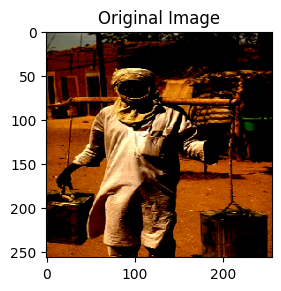

In [ ]:
# Original Image
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title('Original Image')


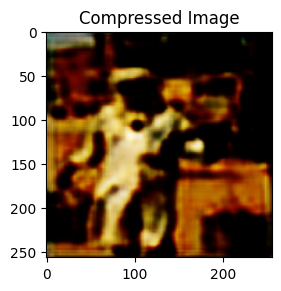

In [ ]:
# Compressed Image
plt.subplot(1, 2, 2)
plt.imshow(compressed_image[0])
plt.title('Compressed Image')

plt.show()

Text(0.5, 1.0, 'Difference Image')

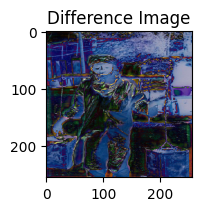

In [ ]:
# Difference Image
difference_image = np.abs(sample_image - compressed_image[0])
plt.subplot(1, 3, 3)
plt.imshow(difference_image)
plt.title('Difference Image')



In [ ]:
print(f"Original Size: {original_size} bytes")
print(f"Compressed Size: {compressed_size} bytes")

Original Size: 786432 bytes
Compressed Size: 786432 bytes


In [ ]:
percentage_difference = ((original_size - compressed_size) / original_size) * 100

print(f"Percentage Difference: {percentage_difference:.2f}%")

Percentage Difference: 0.00%


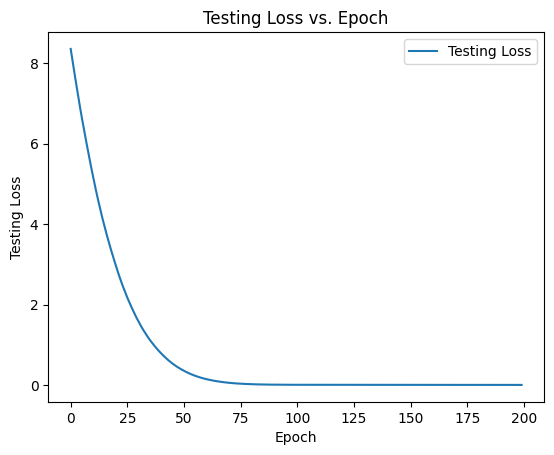

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Generate some dummy data for demonstration purposes
np.random.seed(42)
X_train = np.random.rand(100, 1)
y_train = 3 * X_train + 2 + 0.1 * np.random.randn(100, 1)

X_test = np.random.rand(20, 1)
y_test = 3 * X_test + 2 + 0.1 * np.random.randn(20, 1)

# Build a simple linear regression model
model = Sequential()
model.add(Dense(1, input_dim=1, activation='linear'))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model and store testing loss values
num_epochs = 200
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test), verbose=0)

# Plot testing loss versus epoch
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Testing Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Testing Loss')
plt.legend()
plt.show()
